# Titanic Classification Project

# Table of Contents
* [0. Introduction](#0.-Introduction)
    * [0.1 Introduction to dataset](#0.1-Introduction-to-dataset)
    * [0.2 Overall goal](#0.2-Overall-goal)
    * [0.3 Library imports](#0.3-Library-imports)
* [1. Explatory Data Analysis and Feature Engineering](#1.-Exploratory-Data-Analysis-and-Feature-Engineering)
    * [1.1 Data import and inspection](#1.1-Data-import-and-inspection)
    * [1.2 Overall survival rate](#1.2-Overall-survival-rate)
    * [1.3 Survival rate: gender and passenger class](#1.3-Survival-rate:-gender-and-passenger-class)
    * [1.4 Survival rate: gender and port of embarktion](#1.4-Survival-rate:-gender-and-port-of-embarkation)
    * [1.5 New Feature: Age bins](#1.5-New-feature:-Age-bins)
    * [1.6 New Feature: Title](#1.6-New-Feature:-Title)
    * [1.7 New Feature: Total Family Size](#1.7-New-Feature:-Total-family-size)
    * [1.8 New Feature: Deck](#1.8-New-Feature:-Deck)
* [2. Data preparation and pipeline construction](#2.-Data-preparation-and-pipeline-construction)
    * [2.1: Create transformer for custom features](#2.1:-Create-transformer-for-custom-features)
    * [2.2: Create data pipeline](#2.2:-Create-data-pipeline)
* [3. Model Selection, Tuning, and Emsembling](#3.-Model-Selection,-Tuning,-and-Emsembling)
    * [3.1: Model 1 (Base model) Always predict a passenger dies](#3.1:-Model-1-(Base-model)-Always-predict-a-passenger-dies)
    * [3.2: Model 2: Logistic regression](#3.2:-Model-2:-Logistic-regression)
    * [3.3: Model 3: SVM classifer](#3.3:-Model-3:-SVM-classifer)
    * [3.4: Model 4: Random Forest](#3.4:-Model-4:-Random-Forest)
    * [3.5: Model Tuning](#3.5:-Model-Tuning)
        * [3.5.1: SVM Classifier Tuning](#3.5.1:-SVM-Classifier-Tuning)
        * [3.5.2: Random Forest Classifier Tuning](#3.5.2:-Random-Forest-Classifier-Tuning)
    * [3.6 Model ensembling](#3.6-Model-ensembling)
* [4. Final Predictions](#4.-Final-Predictions)

# 0. Introduction

### 0.1 Introduction to dataset

The dataset we will be working with is a collection of data on the passengers of the Titanic ship.  There are various features for each passenger, and our goal is to predict whether or not a passenger survived when the ship crashed.

Below is a a table that contains the features of the dataset, their definition, a key if applicable, and the respective data type of each.

| Featute  | Definition                                | Key                                             | Data Type   |
|----------|-------------------------------------------|-------------------------------------------------|-------------|
| Survival | Label - If someone survives or not        | 0 = No, 1 = Yes                                 | Categorical |
| Pclass   | Class of a passengers ticket              | 1 = 1st, 2 = 2nd, 3 = 2rd                       | Ordinal     |
| Sex      | A passengers sex (male/female)            |                                                 | Categorical |
| Sibsp    | # of passengers siblings and/or spouses   |                                                 | Numerical   |
| Parch    | # of a passengers parents and/or children |                                                 | Numerical   |
| Ticket   | Ticket number                             |                                                 | Categorical |
| Fare     | Passenger fare                            |                                                 | Numerical   |
| Cabin    | Cabin number                              |                                                 | Categorical |
| Embarked | Port of Embarkation                       | C = Cherbourg, Q = Queenstown, S = Southhampton | Categorical |

### 0.2 Overall goal
Our goal will be to train a machine learning model that can predict (classify) whether or not a passenger of the titanic will survive or not when the ship crashes.  Our measurement of interest will be accuracy.  I will aim for an model that produces an accuracy of at least 80% on the train set (and hopefully the same, or higher, on the test set!)

### 0.3 Library imports
Below I've imported the libraries I'll be using throughout this kernel.

In [1]:
# import necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report

# 1. Exploratory Data Analysis and Feature Engineering
First, we'll perform some explatory data analysis and engineer a few new features.

### 1.1 Data import and inspection
- First I've imported the data and done some preliminary inspections
- There appears to be missing values in the age, cabin, and embarked columns.  I'll deal with these in section 2 of this kernel.

In [2]:
# create paths to training and test data
train_path = '/kaggle/input/titanic/train.csv'
test_path = '/kaggle/input/titanic/test.csv'

# target label in dataset
target = 'Survived'

# to use PassengerId as index
index = 'PassengerId'

# define explicit datatypes for each attribute
dtypes = ({
    'Survived': bool, 
    'Pclass':   'category', 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})

# create seperate dataframes that hold the training and test sets
titanic = pd.read_csv(train_path, index_col=index, dtype=dtypes)
titanic_test = pd.read_csv(test_path, index_col=index, dtype=dtypes)

In [3]:
# look at top of data
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# look at bottom of data
titanic.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,False,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,True,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,False,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,True,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,False,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [5]:
# look at overall structure of data
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    bool    
 1   Pclass    891 non-null    category
 2   Name      891 non-null    category
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    category
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    category
 10  Embarked  889 non-null    category
dtypes: bool(1), category(6), float64(2), int64(2)
memory usage: 109.8 KB


In [6]:
# look at descriptive statistics for numerical features
np.round(titanic.describe(),3)

,Age,SibSp,Parch,Fare
count,714.000,891.000,891.000,891.000
mean,29.699,0.523,0.382,32.204
std,14.526,1.103,0.806,49.693
min,0.420,0.000,0.000,0.000
25%,20.125,0.000,0.000,7.910
50%,28.000,0.000,0.000,14.454
75%,38.000,1.000,0.000,31.000
max,80.000,8.000,6.000,512.329


### 1.2 Overall survival rate
- First I'll look at the overall number of people that survived vs. died
- Then I'll look at a few countplots which demonstrate the number of people who survived/died with detail of a few features

In [7]:
# total number of people who survived vs. died
titanic['Survived'].value_counts()

False    549
True     342
Name: Survived, dtype: int64

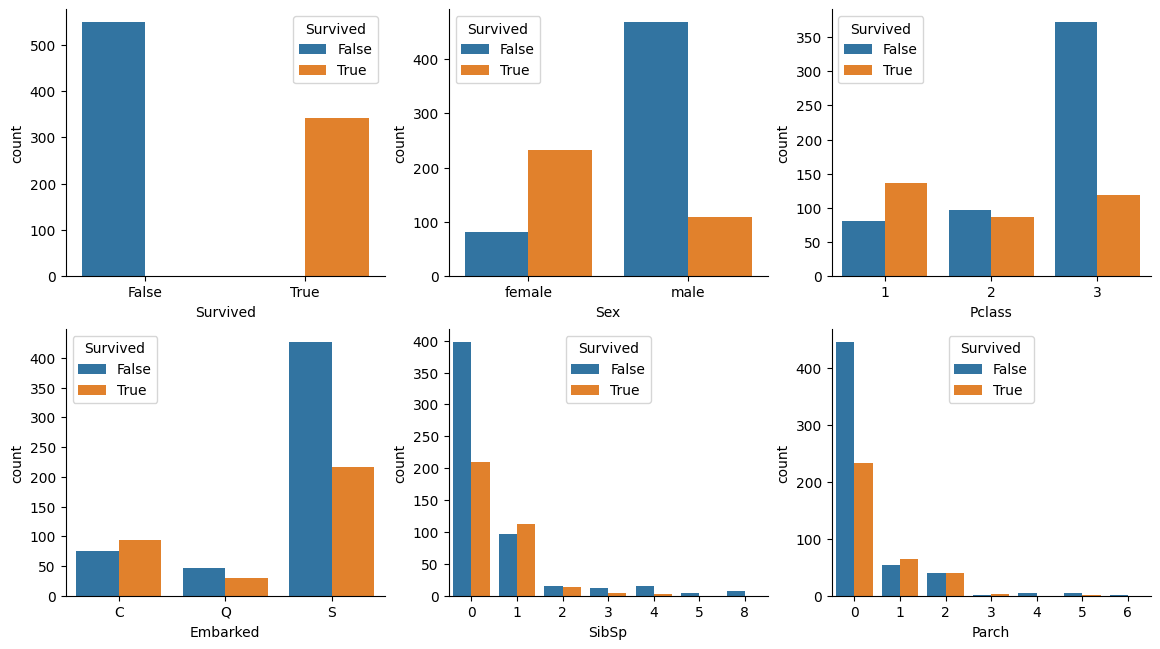

In [8]:
# features to plot in the count plots
attributes = ['Survived', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']

# plot countplots 
plt.figure(figsize=(14, 12), dpi=100)
for i, feature in enumerate(attributes):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=titanic, x=feature, hue='Survived')
    
sns.despine()

### 1.3 Survival rate: gender and passenger class
- Below, I look at survival by gender and further split by passenger class
- Immediately, it's important to notice that on average, females have a much higher survival rate compared to males, especially in classes 1 & 2.

In [9]:
# pivot table that shows mean % of survival for each pclass split by gender
np.round(titanic.pivot_table(values=['Survived'], index=['Sex'], columns=['Pclass'], aggfunc=np.mean), 3)

Survived              
Pclass        1      2      3
Sex                          
female    0.968  0.921  0.500
male      0.369  0.157  0.135

### 1.4 Survival rate: gender and port of embarkation
- Below, I look at survival by gender and further split by port of embarkation
- Similar to section 1.3, it looks like on average women have a higher survival rate, especially for those who departed from Cherbourg.

In [10]:
# pivot table that shows mean % of survival for each port of embarkation split by gender
np.round(titanic.pivot_table(values=['Survived'], index=['Sex'], columns=['Embarked'], aggfunc=np.mean), 3)

Survived              
Embarked        C      Q      S
Sex                            
female      0.877  0.750  0.690
male        0.305  0.073  0.175

### 1.5 New Feature: Age bins
- Below, I create a new categorical feature: age bins
- More specifically I bin the ages into groups of 10 from 0 to 60, and then the remaining older folks into a group of 60+
- Then I look at a pivot table of survival rates for each age bin
- Based on the above, a few key conclusions:
    - Again, notice that females have a much higher survival rate, in group 7 (ages 50-59) 100% survived
    - It looks like for most groups ~80% of men die, besides group 1(ages 0-9).
    - It's looking like age is going to be a very strong predictive feature.

In [11]:
# create new feature: age bins
bins = [0., 10., 20., 30., 40., 50., 60., np.inf]
titanic['age_cat'] = np.searchsorted(bins, titanic['Age'].values)

In [12]:
# pivot table that shows mean % of survival for each pclass split by gender
np.round(titanic.pivot_table(values=['Survived'], index=['Sex'], columns=['age_cat'], aggfunc=np.mean), 3)

Survived                                                 
age_cat        1      2      3      4      5      6      7      8
Sex                                                              
female     0.613  0.739  0.753  0.836  0.677  0.929  1.000  0.679
male       0.576  0.145  0.154  0.230  0.218  0.143  0.105  0.129

### 1.6 New Feature: Title
- Below, I create a new categorical feature: title.
- This was extracted from each passengers name.
- Some examples would be 'Mr', 'Mrs.', etc.
- A key conclusion is that those with titles 'Mrs', 'Miss', and 'Master' had higher survival rates that 'Mr'.

In [13]:
# look at first 5 names to identify pattern in strings
titanic['Name'].iloc[0:5]

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: category
Categories (891, object): ['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward', 'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel', ..., 'de Pelsmaeker, Mr. Alfons', 'del Carlo, Mr. Sebastiano', 'van Billiard, Mr. Austin Blyler', 'van Melkebeke, Mr. Philemon']

In [14]:
# crate function to extract a passengers title from name feature
def get_title(name):
    return re.split(',|\.', name)[1].strip()

# create new title feature
titanic['title'] = titanic['Name'].apply(get_title)

In [15]:
# create dataframe that shows titles along with counts and mean survival rate
titles = titanic.groupby('title').agg({'Survived': ['count', 'mean']})

# drop top level of multi-layer index from above
titles.columns = titles.columns.droplevel()

# sort data frame by mean survival rate from highest to lowest
titles.sort_values('mean', ascending=False)

,count,mean
title,,
the Countess,1,1.000000
Mlle,2,1.000000
Sir,1,1.000000
Ms,1,1.000000
Lady,1,1.000000
Mme,1,1.000000
Mrs,125,0.792000
Miss,182,0.697802
Master,40,0.575000


It looks like there are several titles where there are only 1 - 10 passengers with the title.  I'll group these into one category called 'other' to reduce cardinality.

In [16]:
# list of titles to replace with 'other'
uncommon_titles = (['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 
                    'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                    'the Countess', 'Jonkheer'])

# replace uncommon titles with 'other'
titanic['title'] = titanic['title'].replace(uncommon_titles, 'other')

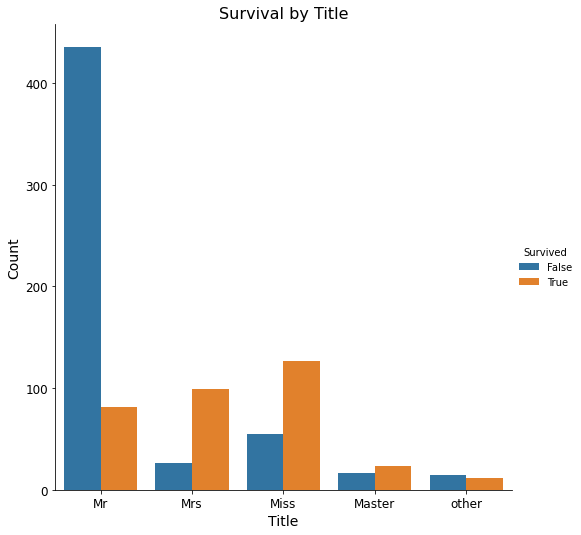

In [17]:
# count plot of titles showing portion of those that died
sns.catplot(x='title', kind='count', hue='Survived', data=titanic, height=7)
plt.tick_params(labelsize=12)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Title', fontsize=14)
plt.title('Survival by Title', fontdict={'fontsize':16});

### 1.7 New Feature: Total family size
- Below, I create a new categorical feature: total family size
- This feature is a combination of the features sibsp (siblings/spouse) and parch (parents/children)
- A family size of 0 means that a passenger was alone on the ride
- It looks like survival rates were higher for families of size 1, 2, 3.

In [18]:
# create new feature: family size
titanic['fam_size'] = titanic['SibSp'] + titanic['Parch']

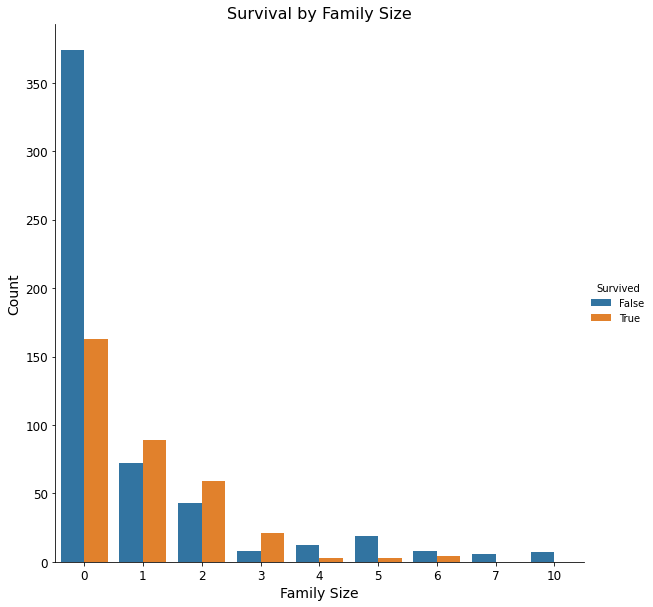

In [19]:
# count plot of family sizes showing portion of those that died
sns.catplot(x='fam_size', kind='count', hue='Survived', data=titanic, height=8)
plt.tick_params(labelsize=12)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Family Size', fontsize=14)
plt.title('Survival by Family Size', fontdict={'fontsize':16});

### 1.8 New Feature: Deck
- Lastly, I create one more new categorical feature: deck
- I derived this from the cabin column by taking just the deck letter (e.g. Deck A, B... and so on).

In [20]:
# create new feature: deck
titanic['deck'] = titanic['Cabin'].apply(lambda x: x[0])

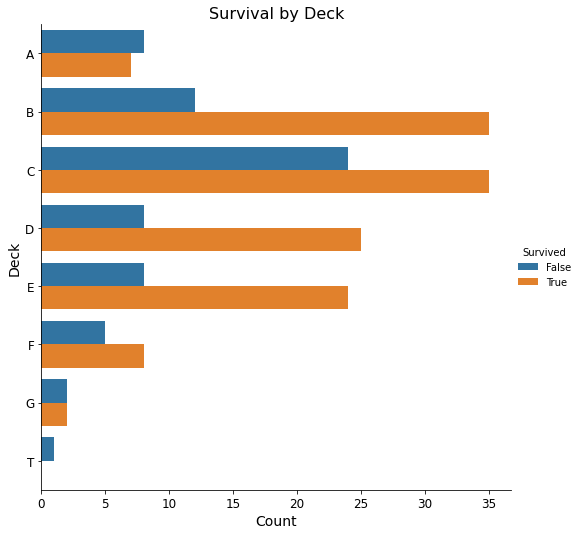

In [21]:
# plot countplot of those who survived vs. died for each deck
sns.catplot(y='deck', hue='Survived', kind='count', data=titanic, 
            order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], height=7)
plt.tick_params(labelsize=12)
plt.ylabel('Deck', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.title('Survival by Deck', fontdict={'fontsize':16});

### 1.9 Missing Data
- Finally, I look at what missing data we have, and decide what to do with each category where there are missing data.

#### 1.9.1 Missing Data - Create summary
- First I created a DataFrame that contains the categories of missing data
- There are two columns, one for the total number of missing datapoints, and one for the total % of missing data in terms of the respective feature.

In [22]:
# create DataFrame that contains missing values
missing = titanic.isnull().sum().sort_values(ascending=False) 
missing = missing[missing > 0]
missing = pd.DataFrame(missing, columns=['total_missing'])

# create column in missing DataFrame that shows total % of missing data
missing['missing_pct'] = np.round(missing['total_missing'] / len(titanic), 3)
missing

,total_missing,missing_pct
Cabin,687,0.771
deck,687,0.771
Age,177,0.199
Embarked,2,0.002


#### 1.9.2: Missing Data: Cabin (and Deck)
- First I'll look at the missing data in the Cabin feature
- Note: I created the 'deck' feature previously in section 1.8.  This contains the same information as the Cabin feature, except simplified in the sense that the 'deck' feature is what deck a passenger was on (A - T), wheras the Cabin feature was a passengers deck and room number.

In [23]:
# create pivot table of deck and passenger class, showing counts for each
titanic.pivot_table(values=['Name'], index=['deck'], columns=['Pclass'], aggfunc='count')

Name      
Pclass    1  2  3
deck             
A        15  0  0
B        47  0  0
C        59  0  0
D        29  4  0
E        25  4  3
F         0  8  5
G         0  0  4
T         1  0  0

In [24]:
# drop deck feature that was created for purposes of data exploration
titanic = titanic.drop('deck', axis=1)

**Conclusion**: 
- Overall, almost 80% of the data in the Cabin/deck features is missing.  This is a significant amount of missing data.  
- I thought I may be able to fill values by drawing some relation to a passengers class, but even based on this it would be difficult to come up with an accurate strategy to fill the missing values.  
- Therefore, the cabin, and the deck feature will be dropped.  Since the deck feature was custom, I've dropped it above.  I'll leave in the cabin feature which will be dropped by our Pipeline I create later in this kernel.

#### 1.9.2: Missing Data: Age
- Next I'll look at the missing data in the Age feature

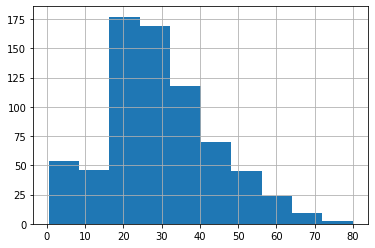

In [25]:
# histogram of ages
titanic['Age'].hist();

In [26]:
# get summary statistics for age feature
titanic['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

**Conclusion**: 
- About 20% of the age data is missing.  I'll fill this with the mean age value (will be built into the pipeline later).

#### 1.9.3: Missing Data: Embarked
- Lastly I'll look at the missing data in the Embarked feature

In [27]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

**Conclusion**: 
- There's only 2 datapoints missing in the Embarked feature
- The most common port of embarkation was 'S', so I'll fill the missing data with this value.

# 2. Data preparation and pipeline construction
Now I'll create a custom transformer and a pipeline for our data

## 2.1: Create transformer for custom features
- First, I'll create a custom transformer with sklearn to create the custom features that I created previously in the data exploration section (age category, title, family size).  The custom transformer will leverage sklearns BaseEstimator and TransformerMixin classes.
- I'll also include an option to turn on the deck feature - however I won't be doing this due to the volume of missing data.  This is rather to show how you can add hyper parameters to custom transformers which could aid in fine tuning an ML model.

In [28]:
# age bins for age category feature
bins = [0., 10., 20., 30., 40., 50., 60., np.inf]

# create class that will create custom features in pipeline
class CustomFeatures(BaseEstimator, TransformerMixin):
    """Represents the custom features added to the Titanic dataset"""
    
    def __init__(self, add_deck_feature=False):
        self.add_deck_feature = add_deck_feature
    
    def fit(self, X, y=None):
        return self    # nothing else to do
    
    def transform(self, X, y=None):
        # create copy of dataset to avoid changes to original
        X = X.copy()
        
        # age category feature
        X['age_cat'] = np.searchsorted(bins, X['Age'].values)

        # title feature
        X['title'] = X['Name'].apply(get_title)
        
        # family size feature
        X['fam_size'] = X['SibSp'] + X['Parch']
        
        # option to add deck feature if wanted
        if self.add_deck_feature:
            X['deck'] = X['Cabin'].apply(lambda x: x[0])
        else:
            pass
        
        return X

In [29]:
# create instance of custom features transformer
custom_features = CustomFeatures()

# add custom features to dataset
titanic = custom_features.transform(titanic)

## 2.2: Create data pipeline
- Now I'll build a data pipeline with sklearn.  
- Pipelines are great as they are extremely efficient.  For example, once the pipeline is built, we can simply call it on the test set and it will perform all the feature engineering etc. for us all at once, rather than having to re-write custom code.
- I'll also split out the labels from the training set in this section.

In [30]:
# create clean training set (split out labels into seperate DataFrame) before data cleaning and transformation
titanic_labels = titanic['Survived'].copy()
titanic = titanic.drop('Survived', axis=1)

In [31]:
# create list of numerical features
titanic_num = titanic.select_dtypes(include=[np.number])
titanic_num = titanic_num.drop(['age_cat'], axis=1)
num_attr = list(titanic_num)

# create list of ordinal features
ord_attr = ['Pclass']

# create list of categorical features
cat_attr = ['Sex', 'Embarked', 'age_cat', 'title']

In [32]:
# create pipleline for numerical features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])

# create pipleline for ordinal features
ord_pipeline = Pipeline([
    ('encoder', OrdinalEncoder(handle_unknown='ignore')),
])

# create pipleline for catgorical features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# create full pipeline to prepare and transform dataset
full_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_attr),
    ('ordinal', ord_pipeline, ord_attr),
    ('categorical', cat_pipeline, cat_attr)],
    remainder='drop')

In [33]:
# create prepared dataset by applying pipeline
titanic_prepared = full_pipeline.fit_transform(titanic)

# cast to dense numpy array (models were getting error w/ sparse matrix?)
titanic_prepared = titanic_prepared.todense()

# 3. Model Selection, Tuning, and Emsembling
- In this section, I'll train a few models and select a winner for further tuning.

## 3.1: Model 1 (Base model) Always predict a passenger dies
- First I'll create and run a base model that always predicts that someone dies.

In [34]:
# create base model - always predicts that someone dies
class AlwaysDieClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [35]:
# create base model classifier
ad_classifier = AlwaysDieClassifier()
ad_pred = ad_classifier.predict(titanic_prepared)

In [36]:
# classification report for base model
print(classification_report(y_true=titanic_labels, y_pred=ad_pred, zero_division=0))

              precision    recall  f1-score   support

       False       0.62      1.00      0.76       549
        True       0.00      0.00      0.00       342

    accuracy                           0.62       891
   macro avg       0.31      0.50      0.38       891
weighted avg       0.38      0.62      0.47       891



## 3.2: Model 2: Logistic regression
- Here I'll test out a standard logistic regression classifier.

In [37]:
# create logistic regression classifier
log_classifier = LogisticRegression(random_state=42)
log_classifier.fit(titanic_prepared, titanic_labels)
log_pred = cross_val_predict(log_classifier, X=titanic_prepared, y=titanic_labels, cv=5)

In [38]:
# classification report for logistic regression model
print(classification_report(y_true=titanic_labels, y_pred=log_pred))

              precision    recall  f1-score   support

       False       0.84      0.87      0.85       549
        True       0.78      0.73      0.75       342

    accuracy                           0.82       891
   macro avg       0.81      0.80      0.80       891
weighted avg       0.82      0.82      0.82       891



## 3.3: Model 3: SVM classifer
- Here I'll test out a SVM classifier model.

In [39]:
# create SVM regression classifier
svm_classifier = SVC(random_state=42)
svm_classifier.fit(titanic_prepared, titanic_labels)
svm_pred = cross_val_predict(svm_classifier, X=titanic_prepared, y=titanic_labels, cv=5)

In [40]:
# classification report for SVM classifier model
print(classification_report(y_true=titanic_labels, y_pred=svm_pred))

              precision    recall  f1-score   support

       False       0.84      0.89      0.87       549
        True       0.81      0.73      0.77       342

    accuracy                           0.83       891
   macro avg       0.83      0.81      0.82       891
weighted avg       0.83      0.83      0.83       891



## 3.4: Model 4: Random Forest
- Here I'll test out a Random Forest classifier model.

In [41]:
# create Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(titanic_prepared, titanic_labels)
rf_pred = cross_val_predict(rf_classifier, X=titanic_prepared, y=titanic_labels, cv=5)

In [42]:
# classification report for random forest classifier model
print(classification_report(y_true=titanic_labels, y_pred=rf_pred))

              precision    recall  f1-score   support

       False       0.84      0.86      0.85       549
        True       0.77      0.75      0.76       342

    accuracy                           0.82       891
   macro avg       0.81      0.80      0.80       891
weighted avg       0.82      0.82      0.82       891



## 3.5: Model Tuning
- Based on the above results, I will tune an SVM classifier and a Random Forest classifier to try to improve performance.
- I'll then ensemble them together into a voting classifier model.

### 3.5.1: SVM Classifier Tuning

In [43]:
#parameters for SVM parameter grid
C = [0.1, 0.5, 0.75, 1, 2, 5, 10]
kernel = ['linear', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']

# create SVM parameter grid
svm_param_grid = [{'C':C,
                   'kernel':kernel,
                   'gamma':gamma}]

# create SVM classifier
svm_classifier = SVC(random_state=42)

# create grid search for SVM model
svm_grid_search = GridSearchCV(svm_classifier, param_grid=svm_param_grid, cv=5,
                               return_train_score=True)

# fit grid search
svm_grid_search.fit(titanic_prepared, titanic_labels)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid=[{'C': [0.1, 0.5, 0.75, 1, 2, 5, 10],
                          'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'rbf', 'sigmoid']}],
             return_train_score=True)

In [44]:
# get best parameters for SVM grid search
svm_grid_search.best_params_

{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}

In [45]:
# save the best model
svm_classifier_best = svm_grid_search.best_estimator_

In [46]:
# classification report for SVM classifier model
svm_pred = cross_val_predict(svm_classifier, X=titanic_prepared, y=titanic_labels, cv=5)
print(classification_report(y_true=titanic_labels, y_pred=svm_pred))

              precision    recall  f1-score   support

       False       0.84      0.89      0.87       549
        True       0.81      0.73      0.77       342

    accuracy                           0.83       891
   macro avg       0.83      0.81      0.82       891
weighted avg       0.83      0.83      0.83       891



### 3.5.2: Random Forest Classifier Tuning

In [47]:
#parameters for rf parameter grid
n_estimators = [2, 4, 8, 16, 32 ,64, 128, 256]
max_features = [2, 3, 4, 5, 6, 7, 8]
bootstrap = [True, False]

# create rf parameter grid
rf_param_grid = {'n_estimators':n_estimators,
                 'max_features':max_features,
                 'bootstrap':bootstrap}

# create rf classifier
rf_classifier = RandomForestClassifier(random_state=42)

# create grid search for rf model
rf_grid_search = GridSearchCV(rf_classifier, param_grid=rf_param_grid, cv=5,
                               return_train_score=True)

# fit grid search
rf_grid_search.fit(titanic_prepared, titanic_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]},
             return_train_score=True)

In [48]:
# get best parameters for rf grid search
rf_grid_search.best_params_

{'bootstrap': True, 'max_features': 6, 'n_estimators': 64}

In [49]:
# save the best model
rf_classifier_best = rf_grid_search.best_estimator_

In [50]:
# classification report for rf classifier model
rf_pred = cross_val_predict(rf_classifier, X=titanic_prepared, y=titanic_labels, cv=5)
print(classification_report(y_true=titanic_labels, y_pred=rf_pred))

              precision    recall  f1-score   support

       False       0.84      0.86      0.85       549
        True       0.77      0.75      0.76       342

    accuracy                           0.82       891
   macro avg       0.81      0.80      0.80       891
weighted avg       0.82      0.82      0.82       891



## 3.6 Model ensembling
- Finally, I'll ensemble the  best SVM and RF classifier models tuned above and create a voting classifier.

In [51]:
voting_classifier = VotingClassifier(estimators=[('svm', svm_classifier_best), ('rf', rf_classifier_best)])

voting_classifier.fit(titanic_prepared, titanic_labels)

VotingClassifier(estimators=[('svm', SVC(C=5, gamma='auto', random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_features=6,
                                                     n_estimators=64,
                                                     random_state=42))])

# 4. Final Predictions
- First I'll run X_test through the pipeline and then use the voting classifier from above to get the final model predictions.

In [52]:
# X test set
X_test = titanic_test

# add custom features to the test set
X_test = custom_features.transform(X_test)

# transform X test set
X_test_prepared = full_pipeline.transform(X_test)

# cast to dense numpy array (models were getting error w/ sparse matrix?)
X_test_prepared = X_test_prepared.todense()

In [53]:
# get final predictions
predictions = voting_classifier.predict(X_test_prepared).astype(int)

# create output dataframe
output = pd.DataFrame({'PassengerId': titanic_test.index,
                       'Survived': predictions})

# store outputs to csv
output.to_csv('my_submission.csv', index=False)

# Thank you!
Thanks for reviewing my kernel!  This was my first kaggle project and I'm looking forward to doing more.  Any comments/feedback is appreciated!

Cheers,
Nico